# Thêm các thư viện cần dùng

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import joblib
from collections import Counter, defaultdict



# TRÍCH XUẤT ĐẶC TRƯNG

Bởi bộ dữ liệu này quá lớn, vậy nên chúng tôi quyết định dùng 1 phần nhỏ của bộ data này, cụ thể là dữ liệu của năm 2015 để tiến hành phân tích và rút ra các đặc trưng quan trọng trong việc training mô hình

In [2]:
df = pd.read_csv ('./selected_columns.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430755 entries, 0 to 430754
Data columns (total 30 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _MICHD    430755 non-null  int64  
 1   CHOLMED3  430755 non-null  int64  
 2   GENHLTH   430755 non-null  int64  
 3   MAXVO21_  430755 non-null  float64
 4   EMPLOY1   430755 non-null  int64  
 5   BPHIGH6   430755 non-null  int64  
 6   DIABETE4  430755 non-null  int64  
 7   CVDSTRK3  430755 non-null  int64  
 8   _AGE80    430755 non-null  int64  
 9   VETERAN3  430755 non-null  int64  
 10  CHCCOPD3  430755 non-null  int64  
 11  CHILDREN  430755 non-null  int64  
 12  _DRDXAR2  430755 non-null  int64  
 13  DEAF      430755 non-null  int64  
 14  DIFFWALK  430755 non-null  int64  
 15  TOLDHI3   430755 non-null  int64  
 16  PHYSHLTH  430755 non-null  int64  
 17  CHCKDNY2  430755 non-null  int64  
 18  FALL12MN  430755 non-null  int64  
 19  _RFCHOL3  430755 non-null  int64  
 20  TRNS

In [3]:
#Kiểm tra các giá trị của CVDINFR4
df['CVDINFR4'].value_counts()

CVDINFR4
0    407304
1     23451
Name: count, dtype: int64

In [4]:

class KNN:
    def __init__(self, k=7, eps=1e-8):
        self.k = k
        self.eps = eps  # Prevents division by zero
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes = np.unique(y)
        
    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2)**2 + self.eps))  # Add epsilon
    
    def predict(self, X_test):
        y_pred = []
        for x in X_test:
            # Calculate all distances
            distances = [(self.euclidean_distance(x, x_train), y_i) 
                        for x_train, y_i in zip(self.X_train, self.y_train)]
            
            # Get k nearest with distance weighting
            k_nearest = sorted(distances, key=lambda x: x[0])[:self.k]
            class_weights = defaultdict(float)
            
            for dist, label in k_nearest:
                weight = 1 / (dist + self.eps)  # Inverse distance weighting
                class_weights[label] += weight
                
            # Predict class with highest cumulative weight
            if not class_weights:
                y_pred.append(self.classes[0])  # Fallback to first class
            else:
                y_pred.append(max(class_weights, key=class_weights.get))
                
        return np.array(y_pred)
    
    def predict_proba(self, X_test):
        probas = []
        for x in X_test:
            distances = [(self.euclidean_distance(x, x_train), y_i) 
                        for x_train, y_i in zip(self.X_train, self.y_train)]
            
            k_nearest = sorted(distances, key=lambda x: x[0])[:self.k]
            class_weights = defaultdict(float)
            
            # Sum weights per class
            for dist, label in k_nearest:
                weight = 1 / (dist + self.eps)
                class_weights[label] += weight
                
            # Laplace smoothing
            total = sum(class_weights.values()) + len(self.classes)*self.eps
            probabilities = []
            
            for cls in self.classes:
                prob = (class_weights.get(cls, 0) + self.eps) / total
                probabilities.append(prob)
                
            probas.append(probabilities)
            
        return np.array(probas)

In [5]:


def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No CVD', 'CVD'], yticklabels=['No CVD', 'CVD'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
# Hàm đánh giá
def evaluate_model(y_true, y_pred, model_name):
    print(f"Đánh giá cho {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    plot_confusion_matrix(y_true, y_pred, model_name)


In [6]:

# Chuẩn bị dữ liệu
X = df.drop('CVDINFR4', axis=1)
y = df['CVDINFR4']

# Chia tập train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = X_train.sample(frac=0.05, random_state=42)  
y_train = y_train.loc[X_train.index]






Đánh giá cho KNN:
Accuracy: 0.9413
Precision: 0.2141
Recall: 0.0274
F1 Score: 0.0486


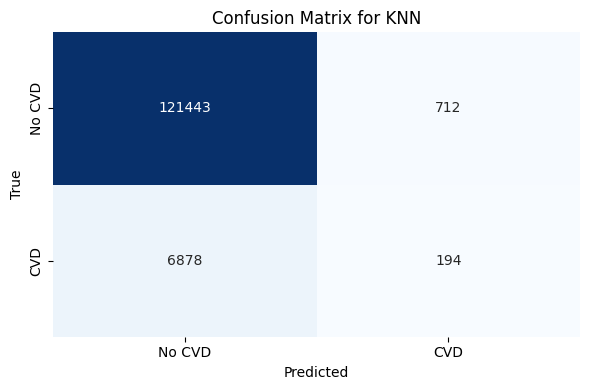

In [7]:
knn = KNN(k=7)
knn.fit(X_train.values, y_train.values)
y_pred_knn = knn.predict(X_test.values)
evaluate_model(y_test, y_pred_knn, "KNN")

In [8]:

joblib.dump(knn, '_knn.pkl')


['_knn.pkl']